   Month  DayofMonth  DayOfWeek  UniqueCarrier  Origin  Dest  Distance  \
0      8          21          7             AA     ATL   DFW       732   
1      4          20          3             US     PIT   MCO       834   
2      9           2          5             XE     RDU   CLE       416   
3     11          25          6             OO     DEN   MEM       872   
4     10           7          6             WN     MDW   OMA       423   

   DepTime_hour  DepTime_minute  UniqueCarrier_freq  Origin_freq  Dest_freq  \
0            19              34            0.090120     0.056935   0.041450   
1            15              48            0.065345     0.006950   0.017615   
2            14              22            0.058685     0.008735   0.011235   
3            10              15            0.076715     0.031110   0.008925   
4            18              28            0.154790     0.012855   0.003435   

   UniqueCarrier    Origin      Dest  
0       0.187938  0.258142  0.151257  
1 

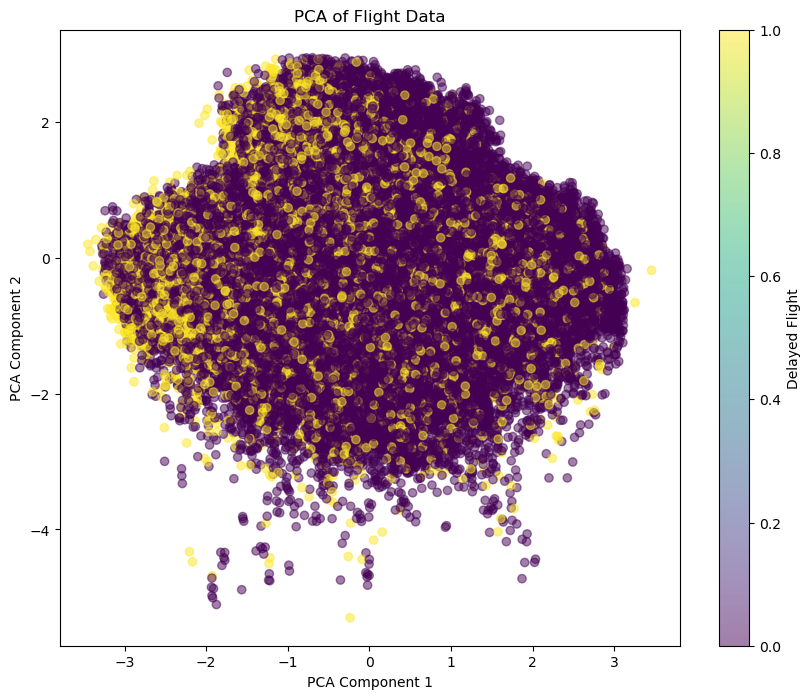

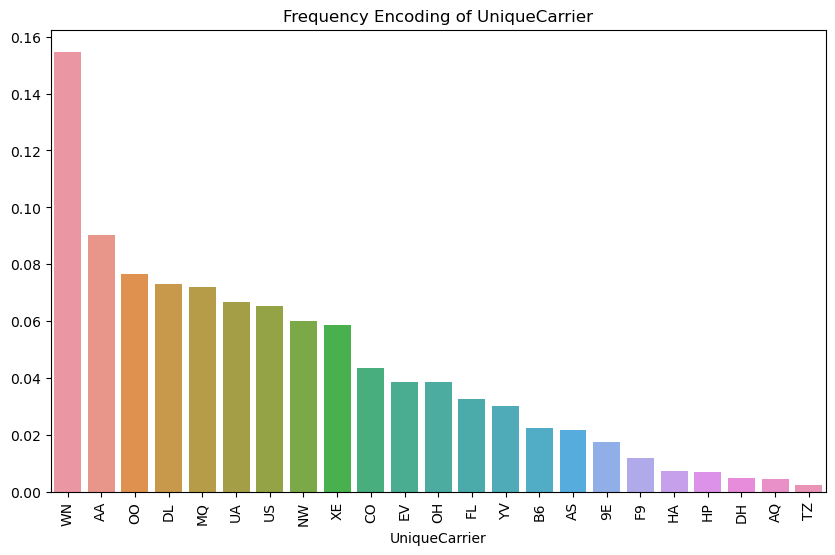

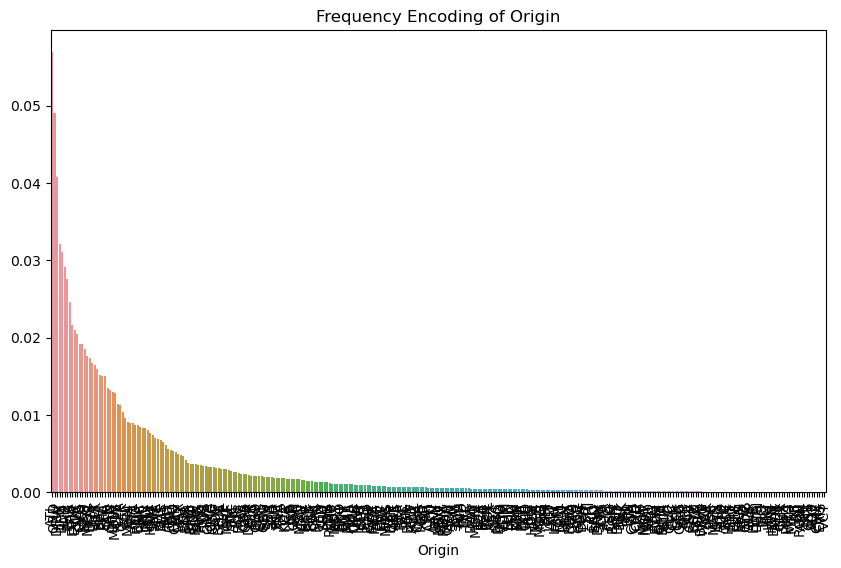

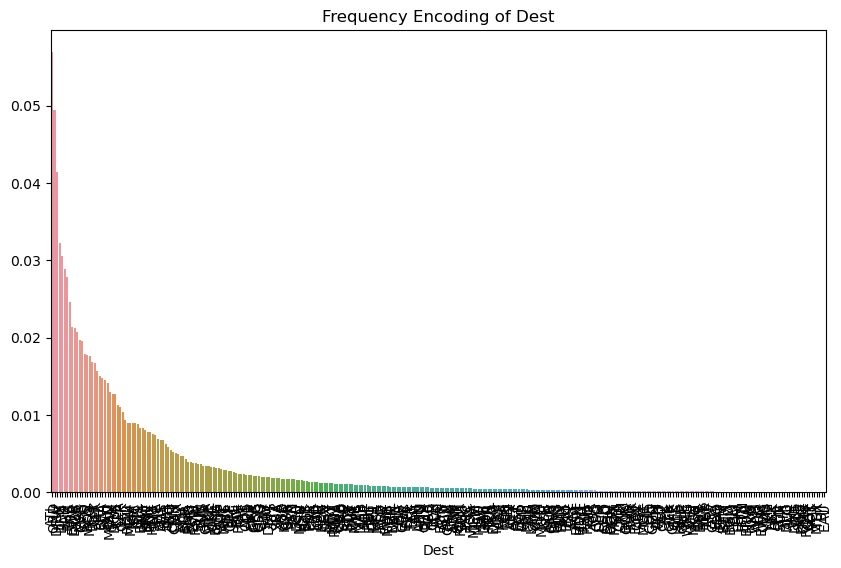

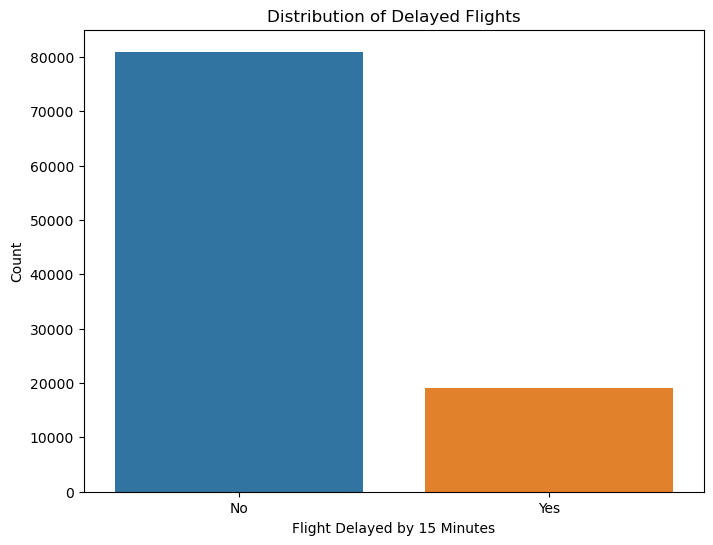

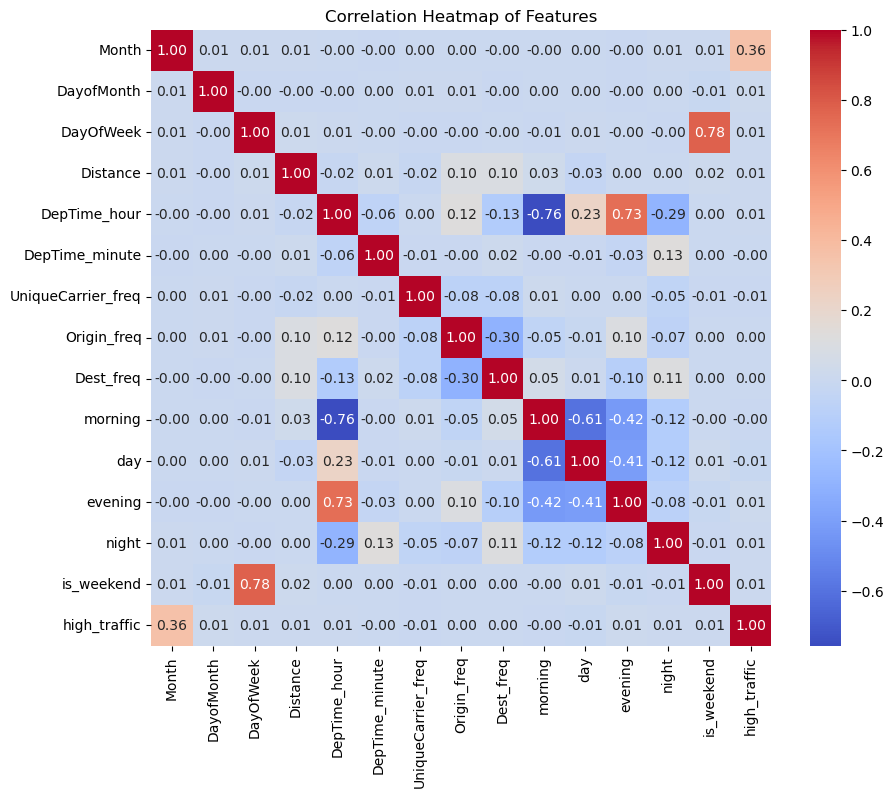

[LightGBM] [Info] Number of positive: 19429, number of negative: 27755
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 47184, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 15543, number of negative: 22204
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 37747, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 15543, number of negative: 22204
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 37747, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM]

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Data preprocessing function
def data_preprocess():
    train_df = pd.read_csv('flight_delays_train.csv')
    test_df = pd.read_csv('flight_delays_test.csv')

    # Convert target labels to binary values
    y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0})
    train_df = train_df.drop(['dep_delayed_15min'], axis=1)

    # Combine train and test for uniform preprocessing
    df = pd.concat([train_df, test_df], sort=False)
    trn_len = train_df.shape[0]

   # Extract date and time information from string columns
    date_columns = ['Month', 'DayofMonth', 'DayOfWeek']
    for column in date_columns:
        df[column] = df[column].str.extract(r'(\d+)', expand=False).astype(int)

    df['DepTime_hour'] = df['DepTime'] // 100
    df['DepTime_minute'] = df['DepTime'] % 100
    df = df.drop(['DepTime'], axis=1)


    # Frequency encoding for categorical columns
    for col in ['UniqueCarrier', 'Origin', 'Dest']:
        freq = df[col].value_counts() / len(df)
        df[col + '_freq'] = df[col].map(freq)

    # Separate train and test sets after encoding
    train_df = df.iloc[:trn_len]
    test_df = df.iloc[trn_len:]

    # Target Encoding of categorical features
    target_encoder = TargetEncoder(cols=['UniqueCarrier', 'Origin', 'Dest'])
    train_encoded = target_encoder.fit_transform(train_df[['UniqueCarrier', 'Origin', 'Dest']], y_train)
    test_encoded = target_encoder.transform(test_df[['UniqueCarrier', 'Origin', 'Dest']])

    # Concatenate encoded features back to original dataframe
    train_df = pd.concat([train_df.reset_index(drop=True), train_encoded.reset_index(drop=True)], axis=1)
    test_df = pd.concat([test_df.reset_index(drop=True), test_encoded.reset_index(drop=True)], axis=1)

    print(train_df.head())

    # Visualization 3: PCA Plot
    # Feature scaling for better model performance and PCA visualization
    scaler = StandardScaler()

    # PCA Plot - Ensure data dimensions match
    X_scaled = scaler.fit_transform(train_df.drop(['UniqueCarrier', 'Origin', 'Dest'], axis=1))
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled)

    plt.figure(figsize=(10, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_train.values, cmap='viridis', alpha=0.5)
    plt.colorbar(label='Delayed Flight')
    plt.title('PCA of Flight Data')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.savefig('pca_plot.png')  # Save the image
    plt.show()
      

    # Visualization 4: Frequency Encoding of Categorical Features
    for col in ['UniqueCarrier', 'Origin', 'Dest']:
        freq = df[col].value_counts() / len(df)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=freq.index, y=freq.values)
        plt.title(f'Frequency Encoding of {col}')
        plt.xticks(rotation=90)
        plt.savefig(f'{col}_frequency_encoding.png')  # Save the image
        plt.show()


    # Drop original categorical columns since they are encoded
    train_df = train_df.drop(['UniqueCarrier', 'Origin', 'Dest'], axis=1)
    test_df = test_df.drop(['UniqueCarrier', 'Origin', 'Dest'], axis=1)

    # Additional time-based features to capture flight patterns
    for df in [train_df, test_df]:
        df['morning'] = ((df['DepTime_hour'] >= 6) & (df['DepTime_hour'] < 12)).astype(int)
        df['day'] = ((df['DepTime_hour'] >= 12) & (df['DepTime_hour'] < 18)).astype(int)
        df['evening'] = ((df['DepTime_hour'] >= 18) & (df['DepTime_hour'] < 24)).astype(int)
        df['night'] = ((df['DepTime_hour'] >= 0) & (df['DepTime_hour'] < 6)).astype(int)
        df['is_weekend'] = (df['DayOfWeek'] > 5).astype(int)
        df['high_traffic'] = (df['Month'].isin([6, 7, 8, 12])).astype(int)

    # Feature scaling for better model performance
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)
    X_test = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

    # Visualization 1: Distribution of Target Variable
    plt.figure(figsize=(8, 6))
    sns.countplot(x=y_train)
    plt.title('Distribution of Delayed Flights')
    plt.xlabel('Flight Delayed by 15 Minutes')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['No', 'Yes'])
    plt.savefig('flight_delay_distribution.png')  # Save the image
    plt.show()

    # Visualization 2: Correlation Heatmap
    plt.figure(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of Features')
    plt.savefig('correlation_heatmap.png')  # Save the image
    plt.show()

  
    
    return X_train, y_train, X_test

# Function to build and train models
def build_models(X_train, y_train):
    # Define multiple models with different configurations
    lgbm = LGBMClassifier(n_estimators=1500, learning_rate=0.03, class_weight='balanced', subsample=0.8, colsample_bytree=0.8, force_col_wise=True)
    xgboost = XGBClassifier(n_estimators=1500, learning_rate=0.03, eval_metric='logloss', scale_pos_weight=5, subsample=0.8, colsample_bytree=0.8)
    catboost = CatBoostClassifier(n_estimators=1500, learning_rate=0.03, eval_metric='Logloss', auto_class_weights='Balanced', verbose=0)

    # Use pipelines to manage model training and feature selection
    base_models = [
        ('lgbm', lgbm),
        ('xgboost', xgboost),
        ('catboost', catboost)
    ]

    # Stack multiple models to create a more robust model
    stacker = StackingClassifier(
        estimators=base_models,
        final_estimator=LogisticRegression(max_iter=200),
        cv=5
    )

    # Voting classifier that aggregates the predictions of all models
    voting_clf = VotingClassifier(estimators=base_models, voting='soft')

    # Perform stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Address class imbalance using oversampling and undersampling techniques
        over = SMOTE(sampling_strategy=0.3, random_state=42)  # Increase the sampling strategy to 0.3
        under = RandomUnderSampler(sampling_strategy=0.7, random_state=42)  # Increase the under-sampling strategy to 0.7
        
         # Apply oversampling first
        X_tr, y_tr = over.fit_resample(X_tr, y_tr)

        # Then apply undersampling
        X_tr, y_tr = under.fit_resample(X_tr, y_tr)

        # Train the stacking model on the training data
        stacker.fit(X_tr, y_tr)
        val_pred = stacker.predict_proba(X_val)[:, 1]
        print('Fold ROC AUC:', roc_auc_score(y_val, val_pred))

    # Fit the final models on the entire training dataset
    voting_clf.fit(X_train, y_train)
    stacker.fit(X_train, y_train)

    return voting_clf, stacker

# Main function to orchestrate data processing, model training, and prediction
def main():

    # Call data_preprocess
    X_train, y_train, X_test = data_preprocess()

    # Build models and generate predictions
    voting_clf, stacker = build_models(X_train, y_train)

    # Combine predictions from both models
    voting_preds = voting_clf.predict_proba(X_test)[:, 1]
    stacker_preds = stacker.predict_proba(X_test)[:, 1]
    final_preds = (voting_preds + stacker_preds) / 2

    # Create the submission file
    submission = pd.DataFrame({'id': np.arange(len(final_preds)), 'dep_delayed_15min': final_preds})
    submission.to_csv('nfinal_stacking_predictions_with_catboost.csv', index=False)

if __name__ == '__main__':
    main()
